In [55]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yahoo_fin import stock_info as si
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('Set3')

import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

# Get data

In [56]:
years = 10
days_required = 365 * years

start_date = dt.datetime.now() - dt.timedelta(days=days_required)
end_date = dt.datetime.now()
data = {}

companies_dow30 = si.tickers_dow()
stocks = list(companies_dow30)

# Fetch the historical data and ticker specific data
for stock in stocks:
    ticker = yf.Ticker(stock)
    hist = ticker.history(start=start_date, end=end_date)
    
    # Include additional info from the .info attribute for each day
    for date in hist.index:
        info = ticker.info
        hist.at[date, 'industry'] = info.get('industry')
        hist.at[date, 'country'] = info.get('country')
        hist.at[date, 'state'] = info.get('state')
        hist.at[date, 'exchange'] = info.get('exchange')
        hist.at[date, 'sector'] = info.get('sector')
        
    
    data[stock] = hist

# Combine and create df
all_data = pd.concat(data)

# basic df maintenance
fin_df = all_data.reset_index().copy()
fin_df.rename(columns={'level_0': 'ticker'}, inplace=True)
fin_df['date'] = fin_df['Date'].dt.strftime('%Y-%m-%d')

# Find New Metrics


In [57]:
def rolling_avgs(df, column):
    """
    Function takes a df and a coulmn from the df and returns a dataframe with the 60,30,10, 5 and 2 day rolling average
    
    """
    df[f'{column}_60_rolling'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(60, 1).mean())
    df[f'{column}_30_rolling'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(30, 1).mean())
    df[f'{column}_10_rolling'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(10, 1).mean())
    df[f'{column}_5_rolling'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(5, 1).mean())
    df[f'{column}_2_rolling'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].transform(lambda x: x.rolling(2, 1).mean())

    return df


In [58]:
fin_df = rolling_avgs(fin_df, 'Close')
fin_df.head()


,ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,industry,country,state,exchange,sector,date,Close_60_rolling,Close_30_rolling,Close_10_rolling,Close_5_rolling,Close_2_rolling
0,AAPL,2014-06-11 00:00:00-04:00,20.815324,20.954640,20.669377,20.755619,182724000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-11,20.755619,20.755619,20.755619,20.755619,20.755619
1,AAPL,2014-06-12 00:00:00-04:00,20.795422,20.813113,20.322196,20.408438,218996000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-12,20.582028,20.582028,20.582028,20.582028,20.582028
2,AAPL,2014-06-13 00:00:00-04:00,20.388536,20.441609,20.096639,20.185093,218100000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-13,20.449717,20.449717,20.449717,20.449717,20.296765
3,AAPL,2014-06-16 00:00:00-04:00,20.235959,20.510165,20.222690,20.388540,142244000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-16,20.434422,20.434422,20.434422,20.434422,20.286817
4,AAPL,2014-06-17 00:00:00-04:00,20.412857,20.499099,20.300080,20.361998,118904000,0.0,0.0,Consumer Electronics,United States,CA,NMS,Technology,2014-06-17,20.419938,20.419938,20.419938,20.419938,20.375269


In [59]:
def calculate_rsi(data, window_size=14):
    data = data.sort_values(by=['ticker', 'Date'])
    data['Price_Change'] = data.groupby('ticker')['Close'].diff()
    data['Gain'] = data['Price_Change'].apply(lambda x: x if x > 0 else 0)
    data['Loss'] = -data['Price_Change'].apply(lambda x: x if x < 0 else 0)
    data['Avg_Gain'] = data.groupby('ticker')['Gain'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    data['Avg_Loss'] = data.groupby('ticker')['Loss'].rolling(window=window_size).mean().reset_index(level=0, drop=True)
    data['RS'] = data['Avg_Gain'] / data['Avg_Loss']
    data['RSI'] = 100 - (100 / (1 + data['RS']))
    return data['RSI']

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data = data.sort_values(by=['ticker', 'Date'])
    data['Short_EMA'] = data.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=short_window, min_periods=1, adjust=False).mean())
    data['Long_EMA'] = data.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=long_window, min_periods=1, adjust=False).mean())
    data['MACD'] = data['Short_EMA'] - data['Long_EMA']
    data['Signal_Line'] = data.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=signal_window, min_periods=1, adjust=False).mean())
    data['MACD_vs_Signal'] = data['MACD'] - data['Signal_Line']
    return data['MACD'], data['Signal_Line'], data['MACD_vs_Signal']

def calculate_bollinger_bands(data, window_size=7, num_std=2):
    data = data.sort_values(by=['ticker', 'Date'])
    data['Rolling_Mean'] = data.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=window_size).mean())
    data['Rolling_STD'] = data.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=window_size).std())
    data['Upper_Band'] = data['Rolling_Mean'] + (data['Rolling_STD'] * num_std)
    data['Lower_Band'] = data['Rolling_Mean'] - (data['Rolling_STD'] * num_std)
    return data['Upper_Band'], data['Lower_Band']


In [60]:
def holiday_days(data):
    data['Days_to_next_holiday'] = (data['Date'] + pd.Timedelta(days=1)).dt.to_period('D').dt.start_time
    data['Days_since_last_holiday'] = (data['Date'] - pd.Timedelta(days=1)).dt.to_period('D').dt.end_time
    data['Days_Remaining_in_Year'] = (pd.to_datetime(data['Date'] + pd.offsets.YearEnd(0))).dt.dayofyear

    return data['Days_to_next_holiday'], data['Days_since_last_holiday'], data['Days_Remaining_in_Year']


In [61]:
# momentum oscillator that measures the speed and change of price movements. 
# The formula for RSI involves calculating average gains and losses over a specified period
fin_df['rsi'] = calculate_rsi(fin_df, window_size=14)

# MACD - momentum indicator that shows the relationship between two moving averages of a security's price.
#If MACD line goes above the Signal line it is considered a good time to invest because short term average has jumped above the long term average
macd_line, signal_line, macd_vs_signal = calculate_macd(fin_df)
fin_df['MACD'] = macd_line
fin_df['Signal_Line'] = signal_line
fin_df['MACD_vs_Signal_Line'] = macd_vs_signal

# Bollinger Bands - two outer bands that are standard deviations away from the middle band. They are used to measure volatility
upper_band, lower_band = calculate_bollinger_bands(fin_df)
fin_df['Upper_Band'] = upper_band
fin_df['Lower_Band'] = lower_band

days_to_next_holiday, days_since_last_holiday, Days_Remaining_in_Year = holiday_days(fin_df)
fin_df['Days_to_Next_Holiday'] = days_to_next_holiday
fin_df['Days_Since_Last_Holiday'] = days_since_last_holiday
fin_df['Days_Remaining_in_Year'] = Days_Remaining_in_Year



In [62]:
fin_df['tomorrow_close'] = fin_df.sort_values(['ticker', 'Date']).groupby('ticker')['Close'].shift(-1)
fin_df = fin_df.dropna(subset=['tomorrow_close'])
fin_df.to_csv('stock_dataset.csv')


# Plot data by ticker


Text(0, 0.5, 'Closing Price')

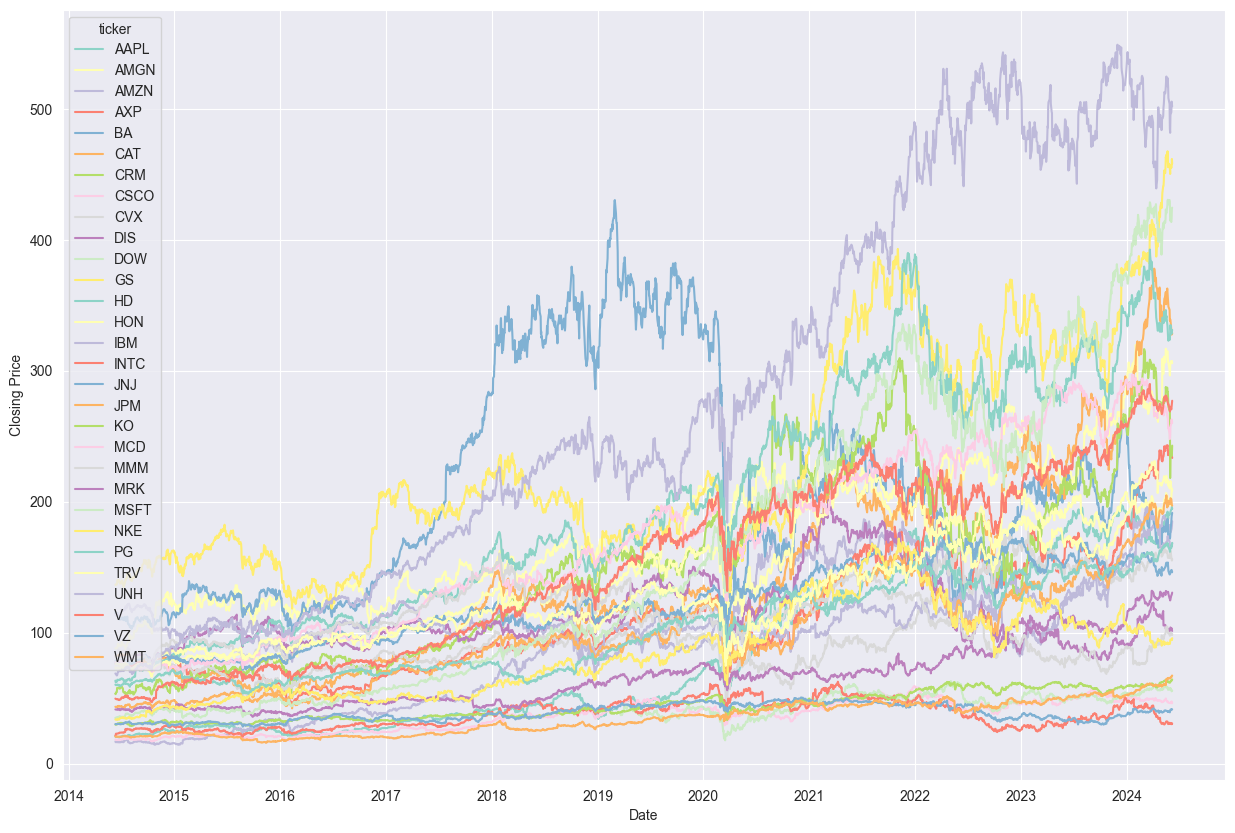

In [63]:
palette = sns.color_palette("Set3", n_colors=30)
plt.figure(figsize=(15,10))
sns.lineplot(data=fin_df, x = 'Date', y = 'Close', hue='ticker', palette=palette)
plt.xlabel('Date')
plt.ylabel('Closing Price')


In [64]:
# palette = sns.color_palette("Set3", n_colors=30)
# fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

# # Plotting rolling_close_10
# sns.lineplot(data=fin_df, x='Date', y='Close_10_rolling', hue='ticker', palette=palette, ax=axes[0], legend=None)
# axes[0].set_title('Rolling Close 10 Days')
# axes[0].set_xlabel('')
# axes[0].set_ylabel('Rolling Close 10')

# # Plotting rolling_close_30
# sns.lineplot(data=fin_df, x='Date', y='Close_30_rolling', hue='ticker', palette=palette, ax=axes[1], legend=None)
# axes[1].set_title('Rolling Close 30 Days')
# axes[1].set_xlabel('')
# axes[1].set_ylabel('Rolling Close 30')

# # Plotting rolling_close_60
# sns.lineplot(data=fin_df, x='Date', y='Close_60_rolling', hue='ticker', palette=palette, ax=axes[2], legend=None)
# axes[2].set_title('Rolling Close 60 Days')
# axes[2].set_xlabel('Date')
# axes[2].set_ylabel('Rolling Close 60')

# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout(rect=[0, 0, 0.85, 1]) 

# # Display the plot
# plt.show()

In [65]:
# num_rows = len(stocks)
# fig, axes = plt.subplots(num_rows, 1, figsize=(10, 2*num_rows), sharex=False)
# current_year = dt.datetime.now().year

# # Plot each stock in a separate subplot
# for i, stock in enumerate(stocks):
#     stock_data = fin_df[(fin_df['ticker'] == stock) & (fin_df['Date'].dt.year >= current_year)]
#     sns.lineplot(data=stock_data, x='Date', y='MACD_vs_Signal_Line',  ax=axes[i])
#     axes[i].set_title(f'{stock} MACD vs Signal Line')
#     axes[i].set_xlabel('Date')
#     axes[i].set_ylabel('MACD vs Signal Line')
#     axes[i].axhline(y=0, color='black', linestyle='--')
# plt.tight_layout()


In [66]:
fin_df = rolling_avgs(fin_df, 'MACD_vs_Signal_Line')
fin_df = rolling_avgs(fin_df, 'Upper_Band')
fin_df = rolling_avgs(fin_df, 'Lower_Band')
fin_df = rolling_avgs(fin_df, 'rsi')

In [70]:
def pivot_point(df):
    """
    This function take on a dataframe that contains the columns High, Low, and Close and calculates the pivot point. The pivot point is the average of these 3 values.
    """
    df['pivot_point'] = (df['Close'] + df['High'] + df['Low']) / 3

    return df


In [67]:
fin_df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'industry', 'country', 'state', 'exchange', 'sector',
       'date', 'Close_60_rolling', 'Close_30_rolling', 'Close_10_rolling',
       'Close_5_rolling', 'Close_2_rolling', 'rsi', 'MACD', 'Signal_Line',
       'MACD_vs_Signal_Line', 'Upper_Band', 'Lower_Band',
       'Days_to_next_holiday', 'Days_since_last_holiday',
       'Days_Remaining_in_Year', 'Days_to_Next_Holiday',
       'Days_Since_Last_Holiday', 'tomorrow_close',
       'MACD_vs_Signal_Line_60_rolling', 'MACD_vs_Signal_Line_30_rolling',
       'MACD_vs_Signal_Line_10_rolling', 'MACD_vs_Signal_Line_5_rolling',
       'MACD_vs_Signal_Line_2_rolling', 'Upper_Band_60_rolling',
       'Upper_Band_30_rolling', 'Upper_Band_10_rolling',
       'Upper_Band_5_rolling', 'Upper_Band_2_rolling', 'Lower_Band_60_rolling',
       'Lower_Band_30_rolling', 'Lower_Band_10_rolling',
       'Lower_Band_5_rolling', 'Lower_Band_2_rolling', 'rsi_

In [68]:
features = ['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'industry', 'country', 'state', 'exchange', 'sector',
       'date', 'Close_60_rolling', 'Close_30_rolling', 'Close_10_rolling',
       'Close_5_rolling', 'Close_2_rolling', 'rsi', 'MACD', 'Signal_Line',
       'MACD_vs_Signal_Line', 'Upper_Band', 'Lower_Band',
       'Days_to_next_holiday', 'Days_since_last_holiday',
       'Days_Remaining_in_Year', 'Days_to_Next_Holiday',
       'Days_Since_Last_Holiday', 'tomorrow_close',
       'MACD_vs_Signal_Line_60_rolling', 'MACD_vs_Signal_Line_30_rolling',
       'MACD_vs_Signal_Line_10_rolling', 'MACD_vs_Signal_Line_5_rolling',
       'MACD_vs_Signal_Line_2_rolling', 'Upper_Band_60_rolling',
       'Upper_Band_30_rolling', 'Upper_Band_10_rolling',
       'Upper_Band_5_rolling', 'Upper_Band_2_rolling', 'Lower_Band_60_rolling',
       'Lower_Band_30_rolling', 'Lower_Band_10_rolling',
       'Lower_Band_5_rolling', 'Lower_Band_2_rolling', 'rsi_60_rolling',
       'rsi_30_rolling', 'rsi_10_rolling', 'rsi_5_rolling', 'rsi_2_rolling']



X = fin_df[features]
y = fin_df['tomorrow_close']


KeyError: "['rolling_close_60', 'rolling_close_30', 'rolling_close_10'] not in index"